# Preprocessing with some EDA

In [1]:
# Package Load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# # For colab
# from google.colab import drive
# drive.mount('/content/Mydrive')
# %cd "/content/Mydrive/MyDrive/Github/KT_Devchall"

Drive already mounted at /content/Mydrive; to attempt to forcibly remount, call drive.mount("/content/Mydrive", force_remount=True).
/content/Mydrive/MyDrive/Github/KT_Devchall


## Variable Selection
불필요한 열 제거, 특정 ID 변수를 categorical type으로 변경

In [ ]:
# 불필요한 열
col_notuse = ['ADID', '노출 ID', 'SSP 입찰ID', 'DSP 입찰ID', 'AX 낙찰ID', 'WUID (웹 유저 ID)', '광고 응답 광고주 도메인','OS 버전 ID']
col_use = ['시각', 'ADID 타입', 'DSP ID', '매체 ID', '애드유닛 ID', '플랫폼', 'OS 종류', '사이즈 ID',
       '환율', '광고 응답 소재 카테고리', '국가코드 ID', 'P1', 'P2', 'P3', 'P4', 'P5',
       'winning']

In [ ]:
# # chunk to pickle(train dataset)
# tp = pd.read_csv('dataset_round1/round1_train.csv', iterator=True, chunksize=1000000)
# df = pd.concat(tp, ignore_index=True)
# # df.to_pickle('train_full.pkl')

In [ ]:
# # Data Load/save는 pickle format 이용함
# df = pd.read_pickle('train_full.pkl')

전체 데이터 중
* 낙찰 O : 약 200만개
* 낙찰 X : 약 530만개

> binary classification

### 불필요한 열 제거

In [ ]:
# df.columns

In [ ]:
# for col in df.columns[:-6]:
#     print(f'Unique values of column {col} : {len(df[col].unique())}')

불필요한 열 선정 결과

> Drop cols : ADID, 노출 ID, SSP 입찰ID, DSP 입찰ID, AX 낙찰ID, WUID (웹 유저 ID), 도메인, OS 버전 ID

In [ ]:
# df_cols = df.columns.drop(col_notuse)

In [ ]:
# df = df[df_cols]

In [ ]:
# df.to_pickle('train.pkl') # 4.3s(compressed)

### ID cols to categorical coding

In [ ]:
df = pd.read_csv('dataset_round1/round1_train.csv', usecols=col_use) # 34.3s

In [ ]:
df_test = pd.read_csv('dataset_round1/round1_test.csv', usecols=df.columns.drop(['P5','winning']))

In [ ]:
# DSP ID, 매체 ID, 애드유닛 ID to categorical(from ID to integer)
col_cat = ['DSP ID', '매체 ID', '애드유닛 ID']

In [ ]:
from pandas.api.types import CategoricalDtype
from copy import deepcopy

for col in col_cat:
    series_whole = pd.concat([df[col],df_test[col]]).astype('category').cat.codes + 1
    df[col] = series_whole[:len(df)]
    df_test[col] = series_whole[len(df):]

In [ ]:
df = df.sort_values(by=['시각','winning'])
df_test = df_test.sort_values(by=['시각'])

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
# df.to_pickle('train_1.pkl')
# df_test.to_pickle('test_1.pkl')

In [ ]:
# df.to_pickle('train.pkl') 
# df_test.to_pickle('test.pkl') # 1.6s

## To Datetime
일시 및 초단위 시각을 직접 사용하는 것은 현재 Classification 문제에서 벗어난 Time-series analysis의 관점이므로 일부 변수로만 추출해서 진행

In [ ]:
# # Data Load
# df_train = pd.read_pickle('train.pkl')
# df_train = df_train[df_train.columns.drop(['P5'])] # P5는 사용불가능한 변수이므로 제거

# df_test = pd.read_pickle('test.pkl')

In [4]:
# Data Load for colab (불필요한 변수 선정하는 단계까지 local에서 진행한 후 csv파일 업로드해서 colab에서 작업진행함)
df_train = pd.read_csv('train.csv')
df_train = df_train[df_train.columns.drop(['P5'])] # P5는 사용불가능한 변수이므로 제거

df_test = pd.read_csv('test.csv') # 42s

In [5]:
df_train.시각 = pd.to_datetime(df_train.시각, format='%Y%m%d%H%M%S')
df_test.시각 = pd.to_datetime(df_test.시각, format='%Y%m%d%H%M%S')

In [6]:
# Variable Extraction
# 주말여부
df_train['weekend'] = df_train.시각.dt.dayofweek > 4
df_train['weekend'] = df_train['weekend'].astype('int')
df_test['weekend'] = df_test.시각.dt.dayofweek > 4
df_test['weekend'] = df_test['weekend'].astype('int')

In [7]:
## 시간대
df_train['hour'] = df_train.시각.dt.hour
df_test['hour'] = df_test.시각.dt.hour

In [8]:
## 요일
df_train['dayofweek'] = df_train.시각.dt.dayofweek
df_test['dayofweek'] = df_test.시각.dt.dayofweek

In [9]:
# Datetime 불필요 > 제거
df_train = df_train[df_train.columns.drop('시각')]
df_test = df_test[df_test.columns.drop('시각')]
# df_train.to_pickle('train.pkl')
# df_test.to_pickle('test.pkl')

## Visualization
- Kernel Density Estimation plot으로 가격변수의 분포 확인

### Price Variable Correlation

In [ ]:
# # data load
# df_train = pd.read_pickle('train.pkl')
# df_test = pd.read_pickle('test.pkl')

In [10]:
col_price = ['P1','P2','P3','P4']

In [ ]:
df_train.loc[df_train.winning==1.0, col_price].corr() # 가격변수간 상관계수 탐색(낙찰)

,P1,P2,P3,P4
P1,1.000000,0.576665,0.636191,0.999999
P2,0.576665,1.000000,0.946439,0.576608
P3,0.636191,0.946439,1.000000,0.636141
P4,0.999999,0.576608,0.636141,1.000000


In [ ]:
df_train.loc[df_train.winning==0.0, col_price].corr() # 가격변수간 상관계수 탐색(유찰)

,P1,P2,P3,P4
P1,1.000000,0.709176,0.710066,0.999561
P2,0.709176,1.000000,0.996453,0.719102
P3,0.710066,0.996453,1.000000,0.719804
P4,0.999561,0.719102,0.719804,1.000000


### Data Split for Plotting

In [ ]:
df_win = df_train[df_train.winning==1.0]
df_lose = df_train[df_train.winning==0.0]

In [ ]:
# If normalized?
from copy import deepcopy

df_norm = deepcopy(df_train)
df_minmax = deepcopy(df_train)

for col in col_price:
    df_norm[col] = (df_norm[col]-df_norm[col].mean())/df_norm[col].std()
    df_minmax[col] = (df_minmax[col]-df_minmax[col].min())/(df_minmax[col].max()-df_minmax[col].min())

In [ ]:
df_norm_win = df_norm[df_train.winning==1.0]
df_norm_lose = df_norm[df_train.winning==0.0]

df_minmax_win = df_minmax[df_train.winning==1.0]
df_minmax_lose = df_minmax[df_train.winning==0.0]

### Not-Transformed(Normalized) Plot

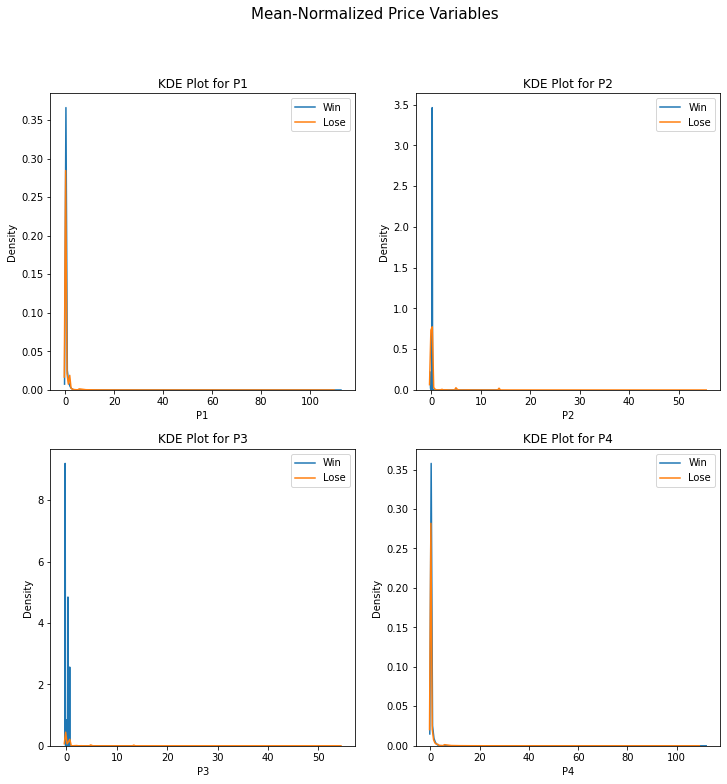

In [ ]:
# Mean-Normalized
fig, axes = plt.subplots(2,2,figsize=(12,12))
for idx, col in enumerate(col_price):
    sns.kdeplot(df_norm_win[col], label='Win', ax=axes[idx//2, idx%2])
    sns.kdeplot(df_norm_lose[col], label='Lose', ax=axes[idx//2, idx%2])
    axes[idx//2,idx%2].legend()
    axes[idx//2,idx%2].set_title(f'KDE Plot for {col}')
plt.suptitle('Mean-Normalized Price Variables', fontsize=15)
plt.show() # 32.3s

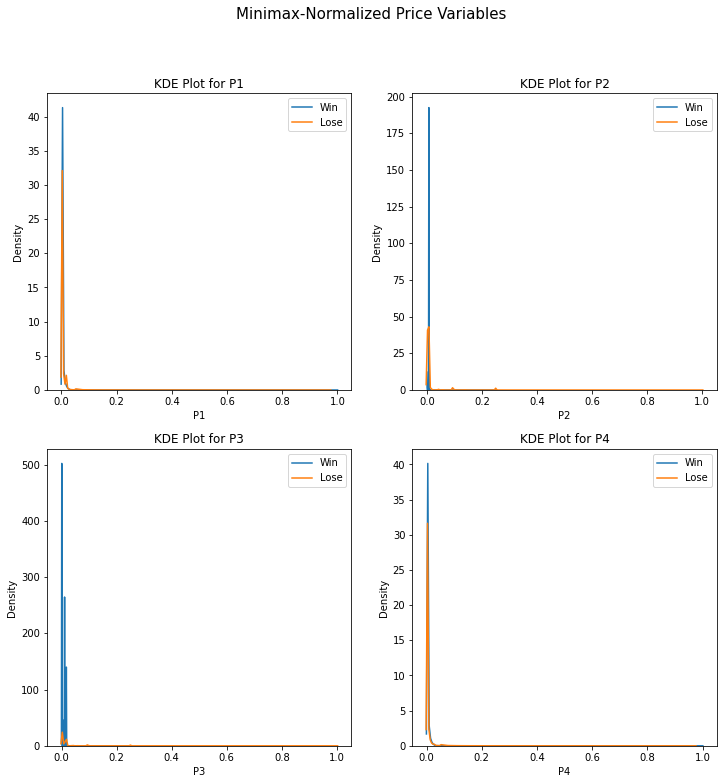

In [ ]:
# Minimax-Normalized
fig, axes = plt.subplots(2,2,figsize=(12,12))
for idx, col in enumerate(col_price):
    sns.kdeplot(df_minmax_win[col], label='Win', ax=axes[idx//2, idx%2])
    sns.kdeplot(df_minmax_lose[col], label='Lose', ax=axes[idx//2, idx%2])
    axes[idx//2,idx%2].legend()
    axes[idx//2,idx%2].set_title(f'KDE Plot for {col}')
plt.suptitle('Minimax-Normalized Price Variables', fontsize=15)
plt.show() # 34.8s

### Log-Transformation
기존 분포에서는 낙찰/유찰 간 가격변수의 분포가 잘 구분되지 않음

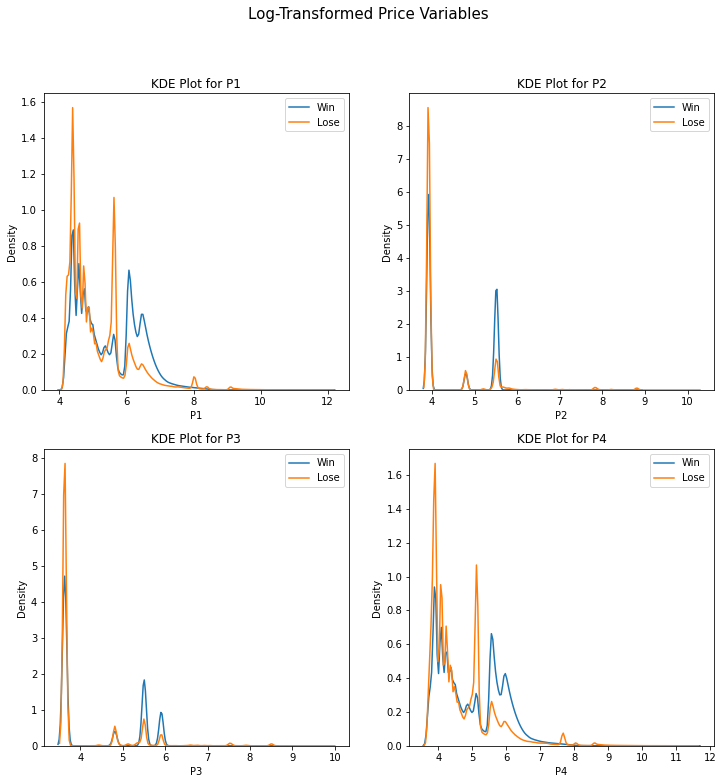

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(12,12))
for idx, col in enumerate(col_price):
    sns.kdeplot(np.log1p(df_win[col]), label='Win', ax=axes[idx//2, idx%2])
    sns.kdeplot(np.log1p(df_lose[col]), label='Lose', ax=axes[idx//2, idx%2])
    axes[idx//2,idx%2].legend()
    axes[idx//2,idx%2].set_title(f'KDE Plot for {col}')
plt.suptitle('Log-Transformed Price Variables', fontsize=15)
plt.show()
plt.savefig('logtransfomred.png', transparent=False)

### 최종 : P1-P4 데이터에 대해 log1p 변환 실행

In [11]:
for col in col_price:
    df_train[col] = np.log1p(df_train[col])
    df_test[col] = np.log1p(df_test[col])

In [ ]:
# df_train.to_pickle('train.pkl') 
# df_test.to_pickle('test.pkl')

## Data Type / Variable Name setting

In [ ]:
# df_train = pd.read_pickle('train.pkl')
# df_test = pd.read_pickle('test.pkl')

In [12]:
df_train = df_train[df_train.columns.drop(['winning']).tolist() + ['winning']] # label 마지막으로

In [13]:
colnames = ['ADID_type', 'DSP_ID', 'Media_ID', 'Adunit_ID', 'Platform', 'OS_type', 'Size_ID',
       'Ex_Rate', 'Category', 'Country_ID', 'P1', 'P2', 'P3', 'P4', 'weekend',
       'hour', 'dayofweek']

In [14]:
df_train.columns = colnames + ['Class']
df_test.columns = colnames

In [15]:
col_int = ['ADID_type', 'DSP_ID', 'Media_ID', 'Adunit_ID', 'Platform', 'OS_type', 'Size_ID',
           'Country_ID', 'weekend', 'hour', 'dayofweek']

In [16]:
# Missing value at Country_ID > treat with Mode
df_train['Country_ID'] = df_train.Country_ID.fillna(df_train.Country_ID.mode()[0])
df_test['Country_ID'] = df_test.Country_ID.fillna(df_test.Country_ID.mode()[0])

In [17]:
# Set integer columns
df_train[col_int] = df_train[col_int].astype('int64')
df_test[col_int] = df_test[col_int].astype('int64')

In [ ]:
# df_train.to_pickle('train.pkl') 
# df_test.to_pickle('test.pkl')

## Category Treatment
- 모든 서브카테고리까지 포함하기에는 너무 많은 variable 생성됨</br>
- 특정 Main Category(0~26, 0:NA)에 속하는 여부만 파악
> 동시에 여러 카테고리에 속할 경우, 가장 많은 Subcategory를 가진 main category 선택 \\
> 같은 개수의 subcategory일 경우, 가장 앞에 위치한 main category 선택

In [ ]:
# df_train = pd.read_pickle('train.pkl')
# df_test = pd.read_pickle('test.pkl')

In [18]:
# Category fillna with str NA
df_train.Category = df_train.Category.fillna('NA')
df_test.Category = df_test.Category.fillna('NA')

In [19]:
# Category treatment
from tqdm import tqdm
import math

cat_train = []
cat_test = []

for i in tqdm(range(len(df_train))):
    cat_train.append(df_train.Category[i].split('%2C')) # 70s

print(len(cat_train))

for i in tqdm(range(len(df_test))):
    cat_test.append(df_test.Category[i].split('%2C'))

print(len(cat_test))

100%|██████████| 8525512/8525512 [01:36<00:00, 88526.41it/s]


8525512


100%|██████████| 624142/624142 [00:06<00:00, 93504.32it/s]

624142


In [20]:
from collections import Counter

cat_train_treated = [] # for train
for ls in tqdm(cat_train):
    ls_treated = []
    for item in ls:
        if item == 'NA':
            ls_treated.append(0)
        else:
            if item.find('-') == -1:
                ls_treated.append(int(item[3:]))
            else:
                ls_treated.append(int(item[3:item.find('-')]))
    
    if len(ls_treated) == 1:
        cat_train_treated.append(ls_treated[0])
    else:
        cat_train_treated.append(Counter(ls_treated).most_common()[0][0])

print(len(cat_train_treated))

cat_test_treated = [] # for test
for ls in tqdm(cat_test):
    ls_treated = []
    for item in ls:
        if item == 'NA':
            ls_treated.append(0)
        else:
            if item.find('-') == -1:
                ls_treated.append(int(item[3:]))
            else:
                ls_treated.append(int(item[3:item.find('-')]))
    
    if len(ls_treated) == 1:
        cat_test_treated.append(ls_treated[0])
    else:
        cat_test_treated.append(Counter(ls_treated).most_common()[0][0])

print(len(cat_test_treated))

100%|██████████| 8525512/8525512 [00:11<00:00, 711045.26it/s]


8525512


100%|██████████| 624142/624142 [00:01<00:00, 597985.39it/s]

624142


In [21]:
# Merge
df_train['Category'] = cat_train_treated
df_test['Category'] = cat_test_treated

In [22]:
# # For Test data
# for idx, ls in enumerate(tqdm(cat_test_treated)):
#     for item in ls:
#         df_test.iat[idx, 18+item] = 1

In [23]:
# df_train = df_train[df_train.columns.drop(['Category'])]
# df_test = df_test[df_test.columns.drop(['Category'])]

In [24]:
# df_train = df_train[df_train.columns.drop(['Class']).tolist()+['Class']] # Class 맨뒤로 보내기

In [25]:
df_train.to_pickle('data/train_no_ID_treat.pkl') 
df_test.to_pickle('data/test_no_ID_treat.pkl')

# 기타 변수 처리


In [26]:
# DATA load
df_train = pd.read_pickle('data/train_no_ID_treat.pkl')
df_test = pd.read_pickle('data/test_no_ID_treat.pkl') # 25s

### 1. Media_ID
 - Distinct value : 456
 - 최빈값(ID=152)가 전체 데이터의 53.2% at Train
 - 152(=1), 213(=2), 그 외 나머지 값(=3)으로 분류

In [27]:
ls_media_id = []

for val in tqdm(df_train.Media_ID):
    if val == 152:
        ls_media_id.append(1)
    elif val == 213:
        ls_media_id.append(2)
    else:
        ls_media_id.append(3)

df_train.Media_ID = ls_media_id
df_train.head(1)

100%|██████████| 8525512/8525512 [00:04<00:00, 1928875.89it/s]


,ADID_type,DSP_ID,Media_ID,Adunit_ID,Platform,OS_type,Size_ID,Ex_Rate,Category,Country_ID,P1,P2,P3,P4,weekend,hour,dayofweek,Class
0,1,7,3,296,1,1,3,1218.0,22,1012,4.193142,3.918581,3.625407,3.842917,1,0,6,0


In [28]:
df_train.to_pickle('data/train.pkl')

In [29]:
ls_media_id = []

for val in tqdm(df_test.Media_ID):
    if val == 152:
        ls_media_id.append(1)
    elif val == 213:
        ls_media_id.append(2)
    else:
        ls_media_id.append(3)

df_test.Media_ID = ls_media_id
df_test.head(1)

100%|██████████| 624142/624142 [00:00<00:00, 1286225.83it/s]


,ADID_type,DSP_ID,Media_ID,Adunit_ID,Platform,OS_type,Size_ID,Ex_Rate,Category,Country_ID,P1,P2,P3,P4,weekend,hour,dayofweek
0,1,6,1,919,1,1,1,1228.0,0,1012,4.740288,3.926596,3.633367,4.23527,1,0,6


In [30]:
df_test.to_pickle('data/test.pkl')

### 2. Adunit_ID
 - Distinct value : 986
 - 최빈값(ID=919)가 전체 데이터의 53.2% at Train
 - 919(=1), 263(11.5% = 2), 그 외 나머지 값(=3)으로 분류

In [31]:
# DATA load
df_train = pd.read_pickle('data/train.pkl')
df_test = pd.read_pickle('data/test.pkl') # 25s

In [32]:
ls_adunit_id = []

for val in tqdm(df_train.Adunit_ID):
    if val == 919:
        ls_adunit_id.append(1)
    elif val == 263:
        ls_adunit_id.append(2)
    else:
        ls_adunit_id.append(3)

df_train.Adunit_ID = ls_adunit_id
df_train.head(1)

100%|██████████| 8525512/8525512 [00:05<00:00, 1574354.15it/s]


,ADID_type,DSP_ID,Media_ID,Adunit_ID,Platform,OS_type,Size_ID,Ex_Rate,Category,Country_ID,P1,P2,P3,P4,weekend,hour,dayofweek,Class
0,1,7,3,3,1,1,3,1218.0,22,1012,4.193142,3.918581,3.625407,3.842917,1,0,6,0


In [33]:
df_train.to_pickle('data/train.pkl')

In [34]:
ls_adunit_id = []

for val in tqdm(df_test.Adunit_ID):
    if val == 919:
        ls_adunit_id.append(1)
    elif val == 263:
        ls_adunit_id.append(2)
    else:
        ls_adunit_id.append(3)

df_test.Adunit_ID = ls_adunit_id
df_test.head(1)

100%|██████████| 624142/624142 [00:00<00:00, 1604180.49it/s]


,ADID_type,DSP_ID,Media_ID,Adunit_ID,Platform,OS_type,Size_ID,Ex_Rate,Category,Country_ID,P1,P2,P3,P4,weekend,hour,dayofweek
0,1,6,1,1,1,1,1,1228.0,0,1012,4.740288,3.926596,3.633367,4.23527,1,0,6


In [35]:
df_test.to_pickle('data/test.pkl')

# Final Data

In [36]:
df_train.head(5)

,ADID_type,DSP_ID,Media_ID,Adunit_ID,Platform,OS_type,Size_ID,Ex_Rate,Category,Country_ID,P1,P2,P3,P4,weekend,hour,dayofweek,Class
0,1,7,3,3,1,1,3,1218.0,22,1012,4.193142,3.918581,3.625407,3.842917,1,0,6,0
1,1,7,3,3,1,1,3,1218.0,22,1012,4.193142,3.918581,3.625407,3.842917,1,0,6,0
2,1,7,3,3,1,1,3,1218.0,22,1012,4.193142,3.918581,3.625407,3.842917,1,0,6,0
3,1,6,3,3,1,1,2,1218.0,0,1012,7.095744,3.918581,3.625407,6.585471,1,0,6,1
4,5,6,2,2,3,1,3,1218.0,0,1012,6.180696,5.525455,5.499624,5.671248,1,0,6,1
